In [3]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import os
import sys
import importlib

sys.path.insert(0, "..")

import draughts
import board
import preprocessing
import engine

importlib.reload(draughts);
importlib.reload(board);
importlib.reload(preprocessing);
importlib.reload(engine);

In [4]:
my_board = draughts.Board()
my_board

. o . o . o . o
o . o . o . o .
. o . o . o . o
. . . . . . . .
. . . . . . . .
O . O . O . O .
. O . O . O . O
O . O . O . O .

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

tf.config.run_functions_eagerly(True)

In [112]:
def get_conv_net():
    model = keras.models.Sequential()
    model.add(layers.Conv2D(64, (2, 2), activation="relu", input_shape=(8, 8, 5)))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(64, (2, 2), activation="relu"))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D())
#     model.add(layers.Conv2D(128, (2, 2), activation="relu"))
    # model.add(layers.BatchNormalization())
#     model.add(layers.MaxPool2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2()))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation="sigmoid"))

    sgd = keras.optimizers.SGD(learning_rate=0.01)

    model.compile(optimizer=sgd, 
                  loss=keras.losses.MeanSquaredError(), 
                  metrics=["accuracy"])
    
    return model

In [144]:
white_model = get_conv_net()
black_model = get_conv_net()

In [145]:
# white_model.load_weights("new_w_weights.h5")
# black_model.load_weights("new_b_weights.h5")

In [146]:
def get_network_move(output):
    from_index = output[:64].argmax()
    to_index = output[64:].argmax()
    return engine.Move.from_indices(from_index, to_index)

num_dict = {l : i+1 for i, l in enumerate("abcdefgh")}

def cell_dist(cell1, cell2):
    p1 = np.array([num_dict[cell1[0]], int(cell1[1])])
    p2 = np.array([num_dict[cell2[0]], int(cell2[1])])
    return np.linalg.norm(p1 - p2)


def find_closest_move(move, valid_moves):
    distance = np.inf
    best_moves = []
    for m in valid_moves:
        dist = cell_dist(move.from_pos, m.from_pos)
        if dist < distance:
            best_moves.append(m)
            distance = dist
            
    closest_move = None
    distance = np.inf
            
    for m in best_moves:
        dist = cell_dist(move.to_pos, m.to_pos)
        if dist < distance:
            closest_move = m
            distance = dist
            
    return closest_move

In [147]:
my_board = draughts.Board()

white_won = 0
black_won = 0
iter_count = 0

In [148]:
def cost_function(w, b):
    return abs(w - b)

In [149]:
def train():
    
    global my_board
    global white_won
    global black_won
    global iter_count
    
    for i in range(20000):
        iter_count += 1
        if iter_count % 200 == 0:
            white_model.save_weights("new_w_weights.h5")
            black_model.save_weights("new_b_weights.h5")
            
        white_train_data = []
        white_test_data = []

        black_train_data = []
        black_test_data = []

        while my_board.engine.is_finished() == engine.GameState.INDETERMINATE or my_board.engine.is_draw():
            b_valid_moves = my_board.valid_moves()
            
            if len(b_valid_moves) == 0: break
                
            closest_move = None
            inp = preprocessing.board_layout_to_network_input(my_board.engine.layout)
            
            if np.random.randint(4) != 0:
                if my_board.engine.turn:
                    net_move = get_network_move(white_model.predict(np.array([inp]))[0])
                    closest_move = find_closest_move(net_move, b_valid_moves)
                elif not my_board.engine.turn:
                    net_move = get_network_move(black_model.predict(np.array([inp]))[0])
                    closest_move = find_closest_move(net_move, b_valid_moves)
            else:
                closest_move = np.random.choice(b_valid_moves)

            from_in_base = np.zeros(64)
            from_in_base[closest_move.from_index] = 1

            to_in_base = np.zeros(64)
            to_in_base[closest_move.to_index] = 1

            move_out = np.array([*from_in_base, *to_in_base])

            if my_board.engine.turn:
                white_train_data.append(inp)
                white_test_data.append(move_out)
            elif not my_board.engine.turn:
                black_train_data.append(inp)
                black_test_data.append(move_out)
                
            my_board.push_move(closest_move)
            

        if my_board.engine.is_finished() == engine.GameState.WHITE_WON:
            print("White won")
            white_won += 1
            white_model.fit(np.array(white_train_data), np.array(white_test_data), epochs=10, batch_size=32, verbose=0)
        if my_board.engine.is_finished() == engine.GameState.BLACK_WON:
            print("Black won")
            black_won += 1
            black_model.fit(np.array(black_train_data), np.array(black_test_data), epochs=10, batch_size=32, verbose=0)

        print("Board evalutation -", my_board.engine.evaluate())
        print("Game difference function ~", cost_function(white_won, black_won))
        my_board.engine.reset()

In [170]:
# def train_function():
#     try:
#         if iter_count != 20000:
#             train()
#     except:
#         train_function()

# train_function()
# import logging
train()

White won
Board evalutation - 3
Game difference function ~ 16
White won
Board evalutation - 7
Game difference function ~ 17
Black won
Board evalutation - -7
Game difference function ~ 16
White won
Board evalutation - 5
Game difference function ~ 17
Black won
Board evalutation - -4
Game difference function ~ 16
White won
Board evalutation - 5
Game difference function ~ 17
Black won
Board evalutation - -3
Game difference function ~ 16
Black won
Board evalutation - -6
Game difference function ~ 15
Board evalutation - 8
Game difference function ~ 15
White won
Board evalutation - 11
Game difference function ~ 16
White won
Board evalutation - 6
Game difference function ~ 17
White won
Board evalutation - 3
Game difference function ~ 18
White won
Board evalutation - 7
Game difference function ~ 19
White won
Board evalutation - 9
Game difference function ~ 20
White won
Board evalutation - 5
Game difference function ~ 21
White won
Board evalutation - 10
Game difference function ~ 22
Black won
Bo

White won
Board evalutation - 9
Game difference function ~ 16
White won
Board evalutation - 9
Game difference function ~ 17
Black won
Board evalutation - -10
Game difference function ~ 16
White won
Board evalutation - 13
Game difference function ~ 17
Black won
Board evalutation - -7
Game difference function ~ 16
White won
Board evalutation - 10
Game difference function ~ 17
Black won
Board evalutation - -8
Game difference function ~ 16
White won
Board evalutation - 12
Game difference function ~ 17
White won
Board evalutation - 7
Game difference function ~ 18
White won
Board evalutation - 5
Game difference function ~ 19
White won
Board evalutation - 8
Game difference function ~ 20
White won
Board evalutation - 8
Game difference function ~ 21
White won
Board evalutation - 10
Game difference function ~ 22
White won
Board evalutation - 9
Game difference function ~ 23
Black won
Board evalutation - -3
Game difference function ~ 22
White won
Board evalutation - 7
Game difference function ~ 23

White won
Board evalutation - 9
Game difference function ~ 19
Black won
Board evalutation - -7
Game difference function ~ 18
White won
Board evalutation - 8
Game difference function ~ 19
Black won
Board evalutation - -7
Game difference function ~ 18
Board evalutation - -6
Game difference function ~ 18
White won
Board evalutation - 11
Game difference function ~ 19
Black won
Board evalutation - -6
Game difference function ~ 18
White won
Board evalutation - 8
Game difference function ~ 19
White won
Board evalutation - 6
Game difference function ~ 20
White won
Board evalutation - 7
Game difference function ~ 21
White won
Board evalutation - 6
Game difference function ~ 22
White won
Board evalutation - 6
Game difference function ~ 23
White won
Board evalutation - 13
Game difference function ~ 24
White won
Board evalutation - 10
Game difference function ~ 25
Black won
Board evalutation - -7
Game difference function ~ 24
White won
Board evalutation - 11
Game difference function ~ 25
White won

Black won
Board evalutation - -3
Game difference function ~ 38
White won
Board evalutation - 9
Game difference function ~ 39
White won
Board evalutation - 9
Game difference function ~ 40
Black won
Board evalutation - -3
Game difference function ~ 39
Black won
Board evalutation - -6
Game difference function ~ 38
Black won
Board evalutation - -11
Game difference function ~ 37
White won
Board evalutation - 12
Game difference function ~ 38
Black won
Board evalutation - -9
Game difference function ~ 37
Black won
Board evalutation - -4
Game difference function ~ 36
White won
Board evalutation - 7
Game difference function ~ 37
White won
Board evalutation - 9
Game difference function ~ 38
White won
Board evalutation - 7
Game difference function ~ 39
Black won
Board evalutation - -4
Game difference function ~ 38
Black won
Board evalutation - -3
Game difference function ~ 37
White won
Board evalutation - 7
Game difference function ~ 38
White won
Board evalutation - 13
Game difference function ~ 

White won
Board evalutation - 10
Game difference function ~ 46
White won
Board evalutation - 1
Game difference function ~ 47
Black won
Board evalutation - -3
Game difference function ~ 46
White won
Board evalutation - 9
Game difference function ~ 47
White won
Board evalutation - 6
Game difference function ~ 48
Black won
Board evalutation - -6
Game difference function ~ 47
White won
Board evalutation - 12
Game difference function ~ 48
White won
Board evalutation - 9
Game difference function ~ 49
Black won
Board evalutation - -10
Game difference function ~ 48
White won
Board evalutation - 9
Game difference function ~ 49
White won
Board evalutation - 4
Game difference function ~ 50
Black won
Board evalutation - -13
Game difference function ~ 49
Black won
Board evalutation - -9
Game difference function ~ 48
White won
Board evalutation - 9
Game difference function ~ 49
White won
Board evalutation - 6
Game difference function ~ 50
White won
Board evalutation - 11
Game difference function ~ 5

White won
Board evalutation - 4
Game difference function ~ 69
White won
Board evalutation - 7
Game difference function ~ 70
White won
Board evalutation - 10
Game difference function ~ 71
White won
Board evalutation - 11
Game difference function ~ 72
White won
Board evalutation - 5
Game difference function ~ 73
White won
Board evalutation - 9
Game difference function ~ 74
Black won
Board evalutation - -10
Game difference function ~ 73
White won
Board evalutation - 1
Game difference function ~ 74
White won
Board evalutation - 7
Game difference function ~ 75
White won
Board evalutation - 9
Game difference function ~ 76
White won
Board evalutation - 13
Game difference function ~ 77
White won
Board evalutation - 10
Game difference function ~ 78
Black won
Board evalutation - -3
Game difference function ~ 77
Black won
Board evalutation - -3
Game difference function ~ 76
Black won
Board evalutation - -10
Game difference function ~ 75
Black won
Board evalutation - -10
Game difference function ~

Black won
Board evalutation - -3
Game difference function ~ 85
White won
Board evalutation - 12
Game difference function ~ 86
Black won
Board evalutation - -7
Game difference function ~ 85
Black won
Board evalutation - -10
Game difference function ~ 84
Black won
Board evalutation - -4
Game difference function ~ 83
Black won
Board evalutation - -8
Game difference function ~ 82
White won
Board evalutation - 9
Game difference function ~ 83
White won
Board evalutation - 3
Game difference function ~ 84
Black won
Board evalutation - -9
Game difference function ~ 83
Black won
Board evalutation - -8
Game difference function ~ 82
White won
Board evalutation - 3
Game difference function ~ 83
White won
Board evalutation - 8
Game difference function ~ 84
Black won
Board evalutation - -6
Game difference function ~ 83
Black won
Board evalutation - -6
Game difference function ~ 82
White won
Board evalutation - 10
Game difference function ~ 83
Black won
Board evalutation - -4
Game difference function 

Black won
Board evalutation - -9
Game difference function ~ 86
White won
Board evalutation - 9
Game difference function ~ 87
White won
Board evalutation - 4
Game difference function ~ 88
Black won
Board evalutation - -6
Game difference function ~ 87
White won
Board evalutation - 13
Game difference function ~ 88
Black won
Board evalutation - -8
Game difference function ~ 87
White won
Board evalutation - 7
Game difference function ~ 88
White won
Board evalutation - 3
Game difference function ~ 89
Black won
Board evalutation - -6
Game difference function ~ 88
Black won
Board evalutation - -13
Game difference function ~ 87
Board evalutation - 5
Game difference function ~ 87
White won
Board evalutation - 4
Game difference function ~ 88
White won
Board evalutation - 4
Game difference function ~ 89
White won
Board evalutation - 10
Game difference function ~ 90
White won
Board evalutation - 13
Game difference function ~ 91
White won
Board evalutation - 5
Game difference function ~ 92
Black won

Black won
Board evalutation - -8
Game difference function ~ 105
Black won
Board evalutation - -8
Game difference function ~ 104
White won
Board evalutation - 4
Game difference function ~ 105
Black won
Board evalutation - -7
Game difference function ~ 104
Black won
Board evalutation - -3
Game difference function ~ 103
Black won
Board evalutation - -6
Game difference function ~ 102
White won
Board evalutation - 3
Game difference function ~ 103
White won
Board evalutation - 9
Game difference function ~ 104
Black won
Board evalutation - -6
Game difference function ~ 103
Black won
Board evalutation - -5
Game difference function ~ 102
Black won
Board evalutation - -8
Game difference function ~ 101
Black won
Board evalutation - -4
Game difference function ~ 100
White won
Board evalutation - 10
Game difference function ~ 101
White won
Board evalutation - 13
Game difference function ~ 102
White won
Board evalutation - 8
Game difference function ~ 103
White won
Board evalutation - 9
Game differe

Board evalutation - 7
Game difference function ~ 109
Board evalutation - -7
Game difference function ~ 109
White won
Board evalutation - 13
Game difference function ~ 110
Black won
Board evalutation - -4
Game difference function ~ 109
White won
Board evalutation - 15
Game difference function ~ 110
White won
Board evalutation - 8
Game difference function ~ 111
Black won
Board evalutation - -6
Game difference function ~ 110
Black won
Board evalutation - -14
Game difference function ~ 109
Black won
Board evalutation - -7
Game difference function ~ 108
Black won
Board evalutation - -11
Game difference function ~ 107
White won
Board evalutation - 6
Game difference function ~ 108
Board evalutation - 12
Game difference function ~ 108


KeyboardInterrupt: 

In [171]:
iter_count

4243

In [172]:
white_model.save_weights("new_w_weights.h5")
black_model.save_weights("new_b_weights.h5")

In [140]:
my_board.engine.reset()

In [141]:
white_won, black_won

(173, 173)

In [124]:
my_board.engine._fig_count

{'O': 12, 'o': 12, 'X': 0, 'x': 0, '.': 40}

In [125]:
my_board.engine.is_finished()

<GameState.INDETERMINATE: 3>

In [126]:
my_board.valid_moves()

(Move( a3b4 ),
 Move( c3b4 ),
 Move( c3d4 ),
 Move( e3d4 ),
 Move( e3f4 ),
 Move( g3f4 ),
 Move( g3h4 ))

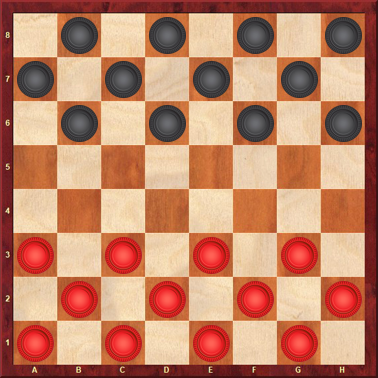

In [127]:
my_board.show()

In [161]:
new_board = draughts.Board()

def play(move):
    new_board.push(move)
    output_vec = black_model.predict(np.array([preprocessing.board_layout_to_network_input(new_board.engine.layout)]))
#     print(output_vec)
    net_move = get_network_move(output_vec[0])
    closest_move = find_closest_move(net_move, new_board.valid_moves())
    print("Network move", net_move)
    print(closest_move)
    new_board.push_move(closest_move)
    display(new_board.show())

Network move Move( d6c5 )
Move( d6e5 )


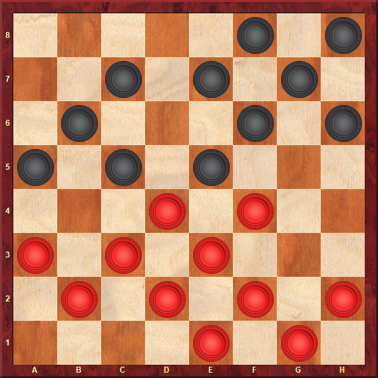

In [169]:
# new_board.push("g7e5")
play("a1b2")

In [675]:
# new_board.show()